# PSSM

In [14]:
import os
import sys
import time
import torch
import torch.nn as nn
import lightning as pl
from torchvision import datasets
from torch.utils.data import DataLoader


In [15]:
from pssm.encoder import PL_PVAE
from pssm.decoder import MLP
from pssm.data import create_decoder_dataset
from pssm.pssm import PoissonSSM


In [19]:
## SET UP DIRECTORIES
name = "pssm"
root_dir = "../data"
data_dir = f"../data/Datasets" 
root_dir = f"{root_dir}/{name}"

load_encoder = True
encoder_dir = "../networks/encoder.ckpt"

load_decoder = False
decoder_dir = "../networks/decoder.ckpt"

# make new checkpoint directory with timestamp
timestamp = time.strftime("%Y%m%d-%H%M%S")
checkpoint_dir = f"{root_dir}/{name}/{timestamp}"
os.makedirs(checkpoint_dir, exist_ok=True)

In [20]:
## SET UP DEVICE
train_device = "0"
device = train_device + "," # lightning device formatting

In [21]:
## GET DATASET
print("Generating encoder dataset...", end=' ')
bsize=256
ds_train = datasets.MNIST(data_dir, train=True, download=True).data
ds_test = datasets.MNIST(data_dir, train=False, download=True).data
ds_train_targets = datasets.MNIST(data_dir, train=True, download=True).targets
ds_test_targets = datasets.MNIST(data_dir, train=False, download=True).targets

ds_train = (ds_train.float().reshape(-1, 784)/255)
ds_test = (ds_test.float().reshape(-1, 784)/255)
ds_train = torch.utils.data.TensorDataset(ds_train, ds_train_targets)
ds_test = torch.utils.data.TensorDataset(ds_test, ds_test_targets)

# Add num_workers for better performance
train_dl = DataLoader(ds_train, batch_size=bsize, shuffle=True, num_workers=4)
val_dl = DataLoader(ds_test, batch_size=bsize, shuffle=False, num_workers=4)
print("Done.")


Generating encoder dataset... Done.


In [22]:
## SET UP ENCODER
if load_encoder:
    print("Loading encoder from checkpoint...", end=' ')
    try:
        encoder = PL_PVAE.load_from_checkpoint(encoder_dir)
        print("Done.")
    except Exception as e:
        print(f"Failed to load encoder from checkpoint: {e}")
        sys.exit(1)
else:
    print("Training encoder...", end=' ')
    encoder = PL_PVAE(len(train_dl))
    trainer_args = {
        "callbacks": [pl.pytorch.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_elbo', save_top_k=1, mode='min', verbose=True)],
        "accelerator": "cpu" if device == 'cpu' else "gpu",
        "gradient_clip_val": 1.0,
    }
    if device != 'cpu':
        trainer_args["devices"] = device
    trainer = pl.Trainer(**trainer_args, default_root_dir=checkpoint_dir, max_epochs=55, num_sanity_val_steps=0)
    trainer.fit(encoder, val_dataloaders=val_dl, train_dataloaders=train_dl)
    print("Done.")


Loading encoder from checkpoint... 1
Done.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
decoder_data, decoder_labels = create_decoder_dataset(encoder, ds_train, n_timesteps=100, n_repeats=5, max_samples=5000, batch_size=5, device=device)







Batch: 100%|██████████| 1/1 [00:15<00:00, 15.23s/it]


In [27]:
decoder_data.shape

torch.Size([5000, 128])

In [ ]:
## SET UP DECODER
if load_decoder:
    print("Loading decoder from checkpoint...", end=' ')
    raise NotImplementedError("Loading decoder from file is not implemented yet.")

else:
    if load_decoder_dataset:
        print("Loading decoder dataset from file...", end=' ')
        # load decoder dataset
        raise NotImplementedError("Loading decoder dataset from file is not implemented yet.")
    else:
        print("Creating decoder dataset...", end=' ')
        device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        # create decoder dataset with encoder model
        decoder_data, decoder_labels = create_decoder_dataset(encoder, ds_train, n_timesteps=100, n_repeats=10, max_samples=10, batch_size=5, device=device)
        # create dataload for decoder
        decoder_ds = torch.utils.data.TensorDataset(decoder_data, decoder_labels)
        print("Done.")
        # save out dataset
        try:
            print("Saving decoder dataset...", end=' ')
            torch.save(decoder_ds, f"{checkpoint_dir}/decoder_dataset.pt")
            print("Done.")
        except Exception as e:
            print(f"Failed to save decoder dataset: {e}")

    decoder_dl = DataLoader(decoder_ds, batch_size=bsize, shuffle=True, num_workers=4)

    print("Training decoder...", end=' ')
    input_size = 128    # Number of neurons
    output_size = 10    # Number of classes

    decoder = MLP(input_size=input_size, output_size=output_size)

    # Define a loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Instead of logistic regression, since logistic is for binary classification
    optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

    decoder.fit(train_loader=decoder_dl, optimizer=optimizer, criterion=criterion, num_epochs=10)
    print("Done.")

    # Save decoder to checkpoint
    try:
        print("Saving decoder checkpoint...", end=' ')
        torch.save(decoder.state_dict(), f"{checkpoint_dir}/decoder.ckpt")
        print("Done.")
    except Exception as e:
        print(f"Failed to save decoder checkpoint: {e}")


In [ ]:
pssm

In [ ]:
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision, math, os, torch
import lightning as pl

name = 'PVAE_minimal' #change to your run name
data_dir = "./Data/Datasets/" #change to your data directory
project_name = "PVAE" #change to your wandb project name
root_dir = "data"
bsize = 256
train_device = "0"
device = train_device + "," #lightning device formatting
checkpoint_dir = os.path.join(root_dir, name)
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
import sys
import os

# Go one level up from the notebooks directory
sys.path.append(os.path.abspath(".."))

from pssm.encoder import PL_PVAE

In [ ]:
ds_train = datasets.MNIST(data_dir, train=True, download=True).data
ds_test = datasets.MNIST(data_dir, train=False, download=True).data

ds_train_targets = datasets.MNIST(data_dir, train=True, download=True).targets
ds_test_targets = datasets.MNIST(data_dir, train=False, download=True).targets

ds_train = (ds_train.float().reshape(-1, 784)/255)
ds_test = (ds_test.float().reshape(-1, 784)/255)
ds_train = torch.utils.data.TensorDataset(ds_train, ds_train_targets)
ds_test = torch.utils.data.TensorDataset(ds_test, ds_test_targets)

# Add num_workers for better performance
train_dl = DataLoader(ds_train, batch_size=bsize, shuffle=True, num_workers=4)
val_dl = DataLoader(ds_test, batch_size=bsize, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.35MB/s]


Extracting ./Data/Datasets/MNIST/raw/train-images-idx3-ubyte.gz to ./Data/Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 264kB/s]


Extracting ./Data/Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ./Data/Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.24MB/s]


Extracting ./Data/Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Data/Datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.43MB/s]

Extracting ./Data/Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Data/Datasets/MNIST/raw



In [ ]:
next(iter(train_dl))[0].shape

torch.Size([256, 784])

In [ ]:
# from pvae.encoder import PL_PVAE

train_model = False

if train_model:
    model = PL_PVAE(train_dl)
    trainer_args = {
        "callbacks": [pl.pytorch.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_elbo', save_top_k=1, mode='min', verbose=True)],
        "accelerator": "cpu" if device == 'cpu' else "gpu",
        "gradient_clip_val": 1.0,
    }
    #trainer_args["logger"].watch(model, log="all")
    if device != 'cpu':
        trainer_args["devices"] = device
    trainer = pl.Trainer(**trainer_args, default_root_dir=checkpoint_dir, max_epochs=55, num_sanity_val_steps=0)
    trainer.fit(model, val_dataloaders=val_dl, train_dataloaders=train_dl)
else:
    f = '../networks/encoder.ckpt'
    model = PL_PVAE.load_from_checkpoint(f, train_dl=train_dl)

1


Using device: mps
target: tensor(8)
torch.Size([78, 1, 128])
torch.Size([1, 128])
torch.Size([78, 1, 128])


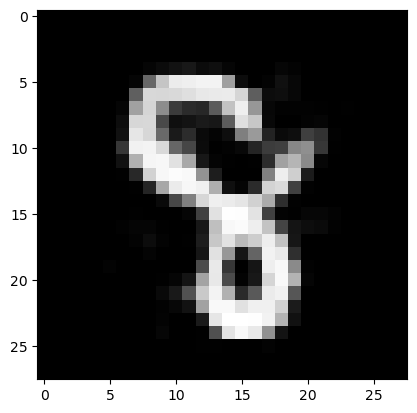

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

batch = next(iter(train_dl))
img = batch[0][0]
target = batch[1][0]

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move model and tensor to the same deviceprint(times.shape)
model = model.to(device)
x = img.to(device)

with torch.no_grad():
    dist, du, z, y = model.forward(x.unsqueeze(0).unsqueeze(0))


plt.imshow(y[0].cpu().numpy().reshape(28, 28), cmap='gray')
print('target:', target)

sample, indicator, times = dist.rsample(hard=True, return_indicator=True)

print(times.shape)
print(sample.shape)
print(indicator.shape)

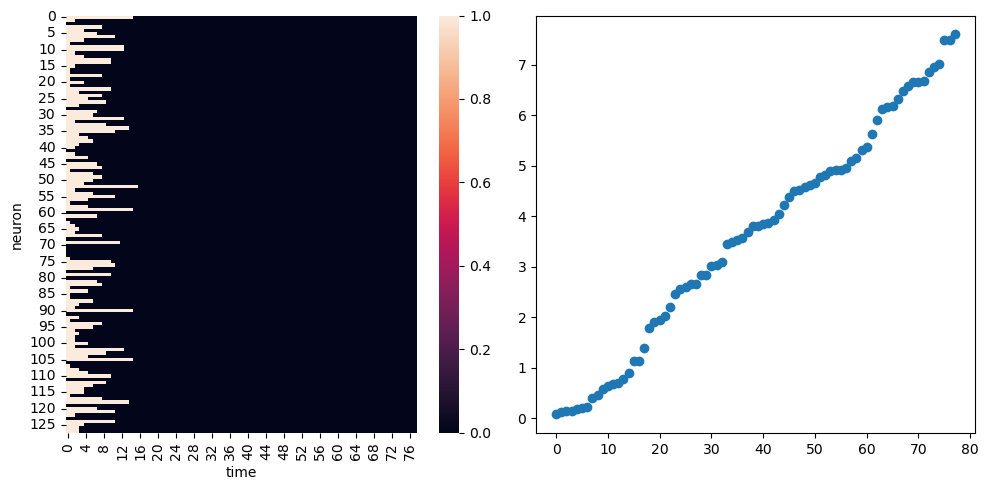

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(indicator[:,0,:].long().cpu().numpy().T, ax=ax[0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('neuron')

t = times[:,0,:][:,0].cpu().numpy()
ax[1].scatter(torch.arange(len(t)), t)

plt.tight_layout()
plt.show()

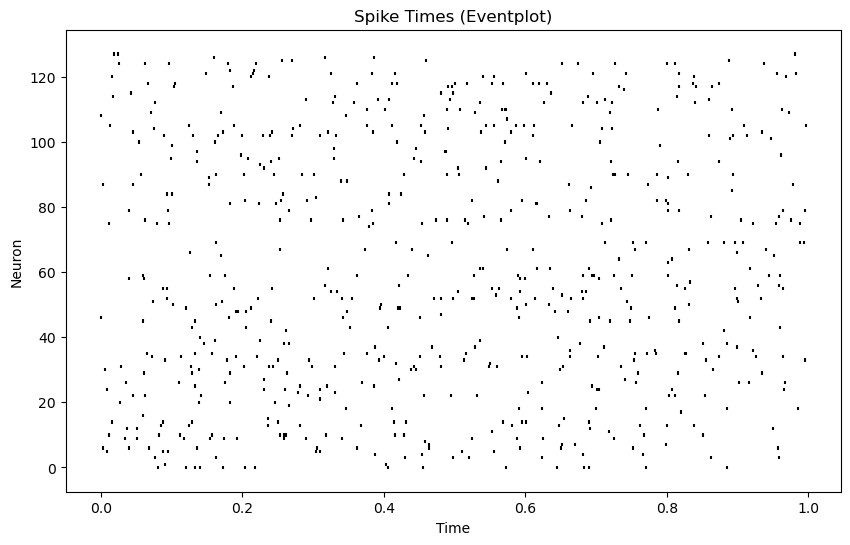

In [ ]:
# Extract the spike times for each neuron
# We use the fact that indicator and times have shape (n_trials, 1, n_neurons)
indicator_np = indicator[:, 0, :].cpu().numpy()  # shape: (n_trials, n_neurons)
times_np = times[:, 0, :].cpu().numpy()          # shape: (n_trials, n_neurons)

# Create one spike train for each neuron based on the indicator mask
spike_trains = [times_np[:, i][indicator_np[:, i]] for i in range(indicator_np.shape[1])]

# Plot the spike times as an eventplot
plt.figure(figsize=(10, 6))
plt.eventplot(spike_trains, colors='black')
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Spike Times (Eventplot)")
plt.show()

In [ ]:
# ULTRA-FAST VERSION - Maximum optimization
from tqdm.notebook import tqdm
from pssm.utils import cumulative_spike_matrix
from torch.utils.data import Subset


n_timesteps = 100   # determines time consant
n_repeats = 10      # Number of repeats for sampling


def create_decoder_dataset_fast(model, dataset, n_timesteps=100, n_repeats=10, max_samples=10000):
    """
    Ultra-fast version that limits the dataset size and uses maximum vectorization.
    """
    model = model.to(device)
    model.eval()
    
    # Limit dataset size for speed
    limited_dataset = torch.utils.data.Subset(dataset, range(min(max_samples, len(dataset))))
    
    # Use DataLoader for better batching
    fast_loader = DataLoader(limited_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    all_data = []
    all_labels = []
    
    with torch.no_grad():
        for batch_imgs, batch_labels in tqdm(fast_loader, desc="Ultra-fast processing"):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            
            # Process each image in the batch
            for img, label in zip(batch_imgs, batch_labels):
                # Get distribution
                dist, du, z, y = model.forward(img.unsqueeze(0).unsqueeze(0))
                
                # Sample multiple times efficiently
                for _ in range(n_repeats):
                    sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
                    cum_matrix = cumulative_spike_matrix(indicator, times, n_steps=n_timesteps)
                    
                    # Add all timesteps at once
                    all_data.append(cum_matrix.T.cpu())  # (n_timesteps, n_neurons)
                    all_labels.extend([label.cpu().item()] * n_timesteps)
    
    # Stack everything
    decoder_data = torch.cat(all_data, dim=0)
    decoder_labels = torch.tensor(all_labels, dtype=torch.long)
    
    return decoder_data, decoder_labels, dist

# Use the ultra-fast version (processes only first 1000 images for speed)
print("Creating decoder dataset with ultra-fast method...")



Creating decoder dataset with ultra-fast method...


In [ ]:
load_decoder = False

if load_decoder:
    # load saved decoder data and labels
    decoder_data_fast = torch.load('./data/decoder/decoder_data_fast.pt')
    decoder_labels_fast = torch.load('./data/decoder/decoder_labels_fast.pt')
else:
    decoder_data_fast, decoder_labels_fast, dist_fast = create_decoder_dataset_fast(
        model, ds_train, n_timesteps=n_timesteps, n_repeats=n_repeats, max_samples=7
        )

    # Save decoder data and labels
    torch.save(decoder_data_fast, './data/decoder/decoder_data_fast.pt')
    torch.save(decoder_labels_fast, './data/decoder/decoder_labels_fast.pt')


print(f"Fast decoder data shape: {decoder_data_fast.shape}")
print(f"Fast decoder labels shape: {decoder_labels_fast.shape}")

Ultra-fast processing:   0%|          | 0/1 [00:00<?, ?it/s]

Fast decoder data shape: torch.Size([7000, 128])
Fast decoder labels shape: torch.Size([7000])


In [ ]:
# Decoder data is the number of spikes. shape = (n timesteps, n_neurons)
print(decoder_data_fast)

tensor([[ 0,  0,  0,  ...,  0,  1,  0],
        [ 1,  0,  0,  ...,  0,  1,  0],
        [ 1,  0,  0,  ...,  0,  1,  0],
        ...,
        [ 7,  1, 10,  ...,  5,  1,  4],
        [ 7,  1, 10,  ...,  5,  1,  4],
        [ 8,  1, 10,  ...,  5,  1,  4]])


In [ ]:
# decoder labels are the categories. shape = (n timesteps)
decoder_labels_fast

tensor([5, 5, 5,  ..., 1, 1, 1])

In [ ]:
decoder_labels_fast.shape

torch.Size([7000])

In [ ]:
decoder_data_fast.shape

torch.Size([7000, 128])

In [ ]:
# Create a train_loader for the fast decoder data

from torch.utils.data import TensorDataset
dataset = TensorDataset(decoder_data_fast, decoder_labels_fast)
decoder_train_loader_fast = DataLoader(dataset, batch_size=bsize, shuffle=True)
print(f"Fast decoder train loader created with {len(decoder_train_loader_fast.dataset)} samples.")
print(f"Batch size: {bsize}, Number of batches: {len(decoder_train_loader_fast)}")

Fast decoder train loader created with 7000 samples.
Batch size: 256, Number of batches: 28


In [ ]:
from pssm.decoder import MLP

input_size = 128 # ecoder_data_fast.shape[1]  # Number of neurons
output_size = 10  # Number of classes

decoder = MLP(input_size=input_size, output_size=output_size)
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Instead of logistic regression, since logistic is for binary classification
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)

# mlp.train(spike_trains, num_epochs=100, criterion=criterion, optimizer=optimizer, batch_size=32)
decoder.fit(train_loader=decoder_train_loader_fast, optimizer=optimizer, criterion=criterion, num_epochs=100)

# x = x.cpu()
# logits = decoder()
# print("Logits shape:", logits.shape)
# probs = torch.softmax(logits, dim=1)

# Evaluate the MLP
# mlp.evaluate(spike_train_loader)

Epoch [1/100], Loss: 0.6755
Epoch [2/100], Loss: 0.1868
Epoch [3/100], Loss: 0.0809
Epoch [4/100], Loss: 0.1006
Epoch [5/100], Loss: 0.0795
Epoch [6/100], Loss: 0.0602
Epoch [7/100], Loss: 0.0218
Epoch [8/100], Loss: 0.0260
Epoch [9/100], Loss: 0.0139
Epoch [10/100], Loss: 0.0212
Epoch [11/100], Loss: 0.0070
Epoch [12/100], Loss: 0.0174
Epoch [13/100], Loss: 0.0090
Epoch [14/100], Loss: 0.0223
Epoch [15/100], Loss: 0.0030
Epoch [16/100], Loss: 0.0027
Epoch [17/100], Loss: 0.0068
Epoch [18/100], Loss: 0.0021
Epoch [19/100], Loss: 0.0003
Epoch [20/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0006
Epoch [22/100], Loss: 0.0084
Epoch [23/100], Loss: 0.0001
Epoch [24/100], Loss: 0.0141
Epoch [25/100], Loss: 0.0028
Epoch [26/100], Loss: 0.0047
Epoch [27/100], Loss: 0.0024
Epoch [28/100], Loss: 0.0040
Epoch [29/100], Loss: 0.0148
Epoch [30/100], Loss: 0.0003
Epoch [31/100], Loss: 0.0012
Epoch [32/100], Loss: 0.0012
Epoch [33/100], Loss: 0.0030
Epoch [34/100], Loss: 0.0007
Epoch [35/100], Loss: 0

In [ ]:
x = decoder_data_fast[0]   # one sample, shape [784]

print("Input shape:", x.shape)  # [784]

x = x.float()

logits = decoder(x)

# probabilities
probs = torch.softmax(logits, dim=0)

print("Logits shape:", logits)   # [1, 10]
print("Probabilities shape:", probs)  # [1, 10]

Input shape: torch.Size([128])
Logits shape: tensor([ 1.9908, -0.6090,  0.9184, -5.9857, -4.6964,  8.1954, -3.7785, -6.3842,
        -4.2612, -6.2728], grad_fn=<ViewBackward0>)
Probabilities shape: tensor([2.0143e-03, 1.4964e-04, 6.8925e-04, 6.9181e-07, 2.5114e-06, 9.9713e-01,
        6.2889e-06, 4.6442e-07, 3.8809e-06, 5.1913e-07],
       grad_fn=<SoftmaxBackward0>)


In [ ]:
output_size

10

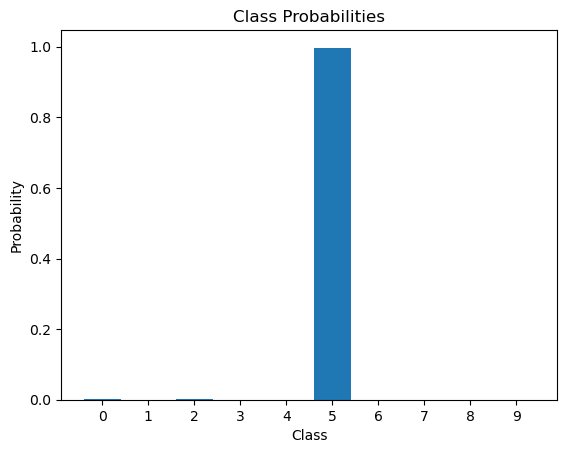

In [ ]:
# plot probabilities over classes
import matplotlib.pyplot as plt
plt.bar(range(output_size), probs.detach().cpu().numpy())
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probabilities')
plt.xticks(range(output_size))
plt.show()